# **Plan de Accion Para el Estado de Nueva York - Proyecto Procesamiento de Datos a Gran Escala**
## **Pontificia Universidad Javeriana**

### **Autores:** 
Juan Guillermo Pabon Vargas y Tomas Alejandro Silva Correal
### **Curso:** 
Procesamiento de Datos a Gran Escala 2530

### **Objetivo:**
El equipo de trabajo ha sido contratado por el estado de Nueva York con el objetivo de ***generar un plan de acción basado en procesamiento de datos a gran escala***, con el punto de utilizar dicho plan de acción para mejorar indicadores territoriales de interés para el equipo de gobierno. Con tal de obtener resultados válidos y contar con recursos amplios, se le ha ofrecido al equipo algunos conjuntos de datos en formato .csv, provenientes de fuentes ofrecidas por el Estado de Nueva York en sí mismo.

Los indicadores que más aquejan al equipo de gobierno que contrató al equipo son **la cantidad de arrestos** y **la cantidad de accidentes viales**, por lo que se le ha suministrado al equipo algunos conjuntos de datos base, con la finalidad de desarrollar un proyecto analítico que permita generar un plan de acción con tal de mejorar dichos indicadores.

A continuación se presentan las fuentes de donde se obtendran los datos a trabajar para generar el plan de acción:
- **Datos respecto a Arrestos** - https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data
- **Datos respecto a Niveles de Pobreza** - https://data.cityofnewyork.us/City-Government/NYCgov-Poverty-Measure-Data-2018-/cts7-vksw/about_data 
- **Datos respecto a Accidentes Viales** - https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4/about_data
- **Datos respecto a Niveles de Educación** - https://data.cityofnewyork.us/Education/2016-2017-Health-Education-Report/2dzy-e7cu 

### **Metodología:**
1. Importación de Librerias
2. Obtenimiento de información respecto a datos del cluster
3. Importación de datos mediante carpetas almacenadas en el cluster
4. Análisis y preparación de datos
5. Se tiene como referencia de calidad los archivos traidos desde las fuentes provistas al cluster donde se trabaja el documento
 

### **1. Importacion de Librerias**

In [1]:
#BIBLIOTECAS INICIALES
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#Bibliotecas especializadas
from pylab import *

In [2]:
#Bibliotecas de PySpark, mllib Y contexto para levantar la sesion de pyspark

#Busqueda e inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F #Acceso a todas las funciones
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

In [3]:
#Se crea una sesion para hacer el contexto de procesamiento desde mi Cuota del Cluster HPC
from pyspark import SparkConf
#Se levanta la configuracion de mi cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")
configura.setAppName("estado_de_los_territorios_de_NY")

spark03 = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark03.sparkContext, sparkSession=spark03)

contextoSpark03 = spark03.sparkContext.getOrCreate()

print("Sesión Cluster HPC: Bernal 25_08_2025")
spark03

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 12:46:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesión Cluster HPC: Bernal 25_08_2025


### **2. Informacion sobre el Cluster**

In [4]:
#Se presenta la configuración de HW y detalles del cluster
cantCPUS =spark03._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion: {cantCPUS}")
print (spark03.sparkContext.getConf().getAll())

Cantidad de CPU's en mi sesion: 1
[('spark.app.startTime', '1761068818617'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.scheduler.mode', 'FAI

### **3. Importacion de los datos**

In [5]:
#Se carga el CSV de 2012 SAT RESULTS como OBJETO DATAFRAME Pyspark 
dfSATR = spark03.read.format("csv").option("header","true").load("NY_Data/2012_SAT_Results_20251014.csv")

In [6]:
#Se carga el CSV de los datos de los arrestos en NY como OBJETO DATAFRAME Pyspark 
dfArrests = spark03.read.format("csv").option("header","true").load("NY_Data/NYPD_Arrest_Data_(Year_to_Date)_20251014.csv")

In [7]:
#Se carga el CSV de los datos de la pobresa en NY como OBJETO DATAFRAME Pyspark 
dfPoverty = spark03.read.format("csv").option("header","true").load("NY_Data/NYCgov_Poverty_Measure_Data_(2018)_20251014.csv")

In [8]:
#Se carga el CSV de los datos de los accidentes de vehiculo en NY como OBJETO DATAFRAME Pyspark 
dfAccidents = spark03.read.format("csv").option("header","true").load("NY_Data/Motor_Vehicle_Collisions_-_Crashes_20251020.csv")

### **4. Analisis y preparacion de los datos**

In [9]:
#Conocimiento de las columnas para puntaje SAT
dfSATR.columns

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score']

In [10]:
#Conocimiento de las columnas para Arrestos
dfArrests.columns

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'New Georeferenced Column']

In [11]:
#Conocimiento de las columnas para valores de pobreza
dfPoverty.columns

['SERIALNO',
 'SPORDER',
 'PWGTP',
 'WGTP',
 'AGEP',
 'CIT',
 'REL',
 'SCH',
 'SCHG',
 'SCHL',
 'SEX',
 'ESR',
 'LANX',
 'ENG',
 'MSP',
 'MAR',
 'WKW',
 'WKHP',
 'DIS',
 'JWTR',
 'NP',
 'TEN',
 'HHT',
 'AgeCateg',
 'Boro',
 'CitizenStatus',
 'EducAttain',
 'EST_Childcare',
 'EST_Commuting',
 'EST_EITC',
 'EST_FICAtax',
 'EST_HEAP',
 'EST_Housing',
 'EST_IncomeTax',
 'EST_MOOP',
 'EST_Nutrition',
 'EST_PovGap',
 'EST_PovGapIndex',
 'Ethnicity',
 'FamType_PU',
 'FTPTWork',
 'INTP_adj',
 'MRGP_adj',
 'NYCgov_Income',
 'NYCgov_Pov_Stat',
 'NYCgov_REL',
 'NYCgov_Threshold',
 'Off_Pov_Stat',
 'Off_Threshold',
 'OI_adj',
 'PA_adj',
 'Povunit_ID',
 'Povunit_Rel',
 'PreTaxIncome_PU',
 'RETP_adj',
 'RNTP_adj',
 'SEMP_adj',
 'SSIP_adj',
 'SSP_adj',
 'TotalWorkHrs_PU',
 'WAGP_adj']

In [12]:
#Conocimiento de las columnas para valores de accidentes
dfAccidents.columns

['CRASH DATE',
 'CRASH TIME',
 'BOROUGH',
 'ZIP CODE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'ON STREET NAME',
 'CROSS STREET NAME',
 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED',
 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED',
 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED',
 'NUMBER OF CYCLIST KILLED',
 'NUMBER OF MOTORIST INJURED',
 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1',
 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3',
 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5',
 'COLLISION_ID',
 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2',
 'VEHICLE TYPE CODE 3',
 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5']

### 4.1 Se presentan las estadísticas de datos a continuación:

In [13]:
#Primero se renombran algunas columnas para evitar problemas a futuro
dfSATR = dfSATR.toDF(*[c.replace('.', '_').replace(' ', '_') for c in dfSATR.columns])

#Se obtiene el resumen de cada columna
for valor in dfSATR.columns:
  dfSATR.describe([valor]).show()

+-------+------+
|summary|   DBN|
+-------+------+
|  count|   478|
|   mean|  NULL|
| stddev|  NULL|
|    min|01M292|
|    max|79X490|
+-------+------+

+-------+--------------------+
|summary|         SCHOOL_NAME|
+-------+--------------------+
|  count|                 478|
|   mean|                NULL|
| stddev|                NULL|
|    min|47 THE AMERICAN S...|
|    max|YOUNG WOMEN'S LEA...|
+-------+--------------------+

+-------+----------------------+
|summary|Num_of_SAT_Test_Takers|
+-------+----------------------+
|  count|                   478|
|   mean|     110.3206650831354|
| stddev|     155.5342536933185|
|    min|                    10|
|    max|                     s|
+-------+----------------------+

+-------+-------------------------------+
|summary|SAT_Critical_Reading_Avg__Score|
+-------+-------------------------------+
|  count|                            478|
|   mean|              400.8503562945368|
| stddev|              56.80278272120784|
|    min|       

In [14]:
#Primero se renombran algunas columnas para evitar problemas 
dfArrests = dfArrests.toDF(*[c.replace('.', '_').replace(' ', '_') for c in dfArrests.columns])

#Se obtiene el resumen de cada columna
for valor in dfArrests.columns:
  dfArrests.describe([valor]).show()

+-------+-------------------+
|summary|         ARREST_KEY|
+-------+-------------------+
|  count|             143494|
|   mean|3.038193365441273E8|
| stddev|  2996610.928069968|
|    min|          298704329|
|    max|          308891972|
+-------+-------------------+

+-------+-----------+
|summary|ARREST_DATE|
+-------+-----------+
|  count|     143494|
|   mean|       NULL|
| stddev|       NULL|
|    min| 01/01/2025|
|    max| 06/30/2025|
+-------+-----------+

+-------+-----------------+
|summary|            PD_CD|
+-------+-----------------+
|  count|           143494|
|   mean|449.6440966172802|
| stddev|274.1730017670755|
|    min|              100|
|    max|              972|
+-------+-----------------+

+-------+--------------------+
|summary|             PD_DESC|
+-------+--------------------+
|  count|              143494|
|   mean|                NULL|
| stddev|                NULL|
|    min|              (null)|
|    max|WEAPONS,MFR,TRANS...|
+-------+--------------------

In [15]:
#Se obtiene el resumen de cada columna
for valor in dfPoverty.columns:
  dfPoverty.describe([valor]).show()

+-------+------------------+
|summary|          SERIALNO|
+-------+------------------+
|  count|             68273|
|   mean| 701952.8149048672|
| stddev|404933.33670966036|
|    min|                 1|
|    max|            999976|
+-------+------------------+

+-------+------------------+
|summary|           SPORDER|
+-------+------------------+
|  count|             68273|
|   mean| 2.311103950317109|
| stddev|1.5867803645948608|
|    min|                 1|
|    max|                 9|
+-------+------------------+

+-------+------------------+
|summary|             PWGTP|
+-------+------------------+
|  count|             68273|
|   mean|120.18007617931438|
| stddev| 87.43245326667459|
|    min|             1,004|
|    max|               997|
+-------+------------------+

+-------+------------------+
|summary|              WGTP|
+-------+------------------+
|  count|             68273|
|   mean|116.19356917893504|
| stddev| 82.34872793997967|
|    min|             1,004|
|    max|  

In [16]:
#Se eliminan los espacios para evitar problemas mas adelante
dfAccidents = dfAccidents.toDF(*[c.replace(' ', '_') for c in dfAccidents.columns])

#Se obtiene el resumen de cada columna
for valor in dfAccidents.columns:
  dfAccidents.describe([valor]).show()

+-------+---------------+
|summary|     CRASH_DATE|
+-------+---------------+
|  count|        2213557|
|   mean|           NULL|
| stddev|           NULL|
|    min| PARKING LOT)."|
|    max|     12/31/2024|
+-------+---------------+



+-------+----------+
|summary|CRASH_TIME|
+-------+----------+
|  count|   2213557|
|   mean|       0.0|
| stddev|      NULL|
|    min|         0|
|    max|      9:59|
+-------+----------+



+-------+-------------+
|summary|      BOROUGH|
+-------+-------------+
|  count|      1534669|
|   mean|          0.0|
| stddev|         NULL|
|    min|            0|
|    max|STATEN ISLAND|
+-------+-------------+



+-------+-----------------+
|summary|         ZIP_CODE|
+-------+-----------------+
|  count|          1534394|
|   mean|10844.12304542895|
| stddev|552.8120774941559|
|    min|                 |
|    max|            11697|
+-------+-----------------+



+-------+------------------+
|summary|          LATITUDE|
+-------+------------------+
|  count|           1973260|
|   mean| 40.59271246258078|
| stddev|2.3089084180575936|
|    min|                 0|
|    max|         43.344444|
+-------+------------------+



+-------+------------------+
|summary|         LONGITUDE|
+-------+------------------+
|  count|           1973260|
|   mean|-73.68847970242868|
| stddev| 4.294190627095948|
|    min|        -201.23706|
|    max|                 0|
+-------+------------------+



+-------+--------------+
|summary|      LOCATION|
+-------+--------------+
|  count|       1973260|
|   mean|           0.0|
| stddev|          NULL|
|    min|    (0.0, 0.0)|
|    max|             0|
+-------+--------------+



+-------+--------------------+
|summary|      ON_STREET_NAME|
+-------+--------------------+
|  count|             1731991|
|   mean|              387.28|
| stddev|   604.6246438907366|
|    min|                 ...|
|    max|estfarms road   ...|
+-------+--------------------+



+-------+--------------------+
|summary|   CROSS_STREET_NAME|
+-------+--------------------+
|  count|             1367911|
|   mean|   81.06307692307693|
| stddev|  309.92976904515746|
|    min|                 ...|
|    max|     �ST 138 STREET|
+-------+--------------------+



+-------+--------------------+
|summary|     OFF_STREET_NAME|
+-------+--------------------+
|  count|              389193|
|   mean|               109.0|
| stddev|                NULL|
|    min|                 ...|
|    max|woodhaven bouleva...|
+-------+--------------------+



+-------+-------------------------+
|summary|NUMBER_OF_PERSONS_INJURED|
+-------+-------------------------+
|  count|                  2213538|
|   mean|       0.3274424597375151|
| stddev|       0.7143080523762174|
|    min|                        0|
|    max|              Unspecified|
+-------+-------------------------+



+-------+------------------------+
|summary|NUMBER_OF_PERSONS_KILLED|
+-------+------------------------+
|  count|                 2213524|
|   mean|    0.001581640858648...|
| stddev|    0.042015099817611715|
|    min|                       0|
|    max|                       8|
+-------+------------------------+



+-------+-----------------------------+
|summary|NUMBER_OF_PEDESTRIANS_INJURED|
+-------+-----------------------------+
|  count|                      2213555|
|   mean|         0.059421609131013235|
| stddev|          0.24968715996818516|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



+-------+----------------------------+
|summary|NUMBER_OF_PEDESTRIANS_KILLED|
+-------+----------------------------+
|  count|                     2213555|
|   mean|        7.815482334976994E-4|
| stddev|         0.02858458927037422|
|    min|                           0|
|    max|                           6|
+-------+----------------------------+



+-------+-------------------------+
|summary|NUMBER_OF_CYCLIST_INJURED|
+-------+-------------------------+
|  count|                  2213556|
|   mean|       1.5159173745773769|
| stddev|       2212.1546294674486|
|    min|                        0|
|    max|                        4|
+-------+-------------------------+



+-------+------------------------+
|summary|NUMBER_OF_CYCLIST_KILLED|
+-------+------------------------+
|  count|                 2213556|
|   mean|    1.251380697565680...|
| stddev|    0.011226129837267047|
|    min|                       0|
|    max|       PASSENGER VEHICLE|
+-------+------------------------+



+-------+--------------------------+
|summary|NUMBER_OF_MOTORIST_INJURED|
+-------+--------------------------+
|  count|                   2213556|
|   mean|       0.23435559541100176|
| stddev|         0.675493205840935|
|    min|                         0|
|    max|         PASSENGER VEHICLE|
+-------+--------------------------+



+-------+-------------------------+
|summary|NUMBER_OF_MOTORIST_KILLED|
+-------+-------------------------+
|  count|                  2213555|
|   mean|     6.451161141241126E-4|
| stddev|     0.027770373483804605|
|    min|                        0|
|    max|                        5|
+-------+-------------------------+



+-------+-----------------------------+
|summary|CONTRIBUTING_FACTOR_VEHICLE_1|
+-------+-----------------------------+
|  count|                      2205757|
|   mean|            72.88288288288288|
| stddev|           22.721131029281867|
|    min|                            1|
|    max|         Windshield Inadeq...|
+-------+-----------------------------+



+-------+-----------------------------+
|summary|CONTRIBUTING_FACTOR_VEHICLE_2|
+-------+-----------------------------+
|  count|                      1858824|
|   mean|            65.37037037037037|
| stddev|           31.271943862422003|
|    min|                            1|
|    max|         Windshield Inadeq...|
+-------+-----------------------------+



+-------+-----------------------------+
|summary|CONTRIBUTING_FACTOR_VEHICLE_3|
+-------+-----------------------------+
|  count|                       160152|
|   mean|                        60.25|
| stddev|                         39.5|
|    min|                            1|
|    max|         View Obstructed/L...|
+-------+-----------------------------+



+-------+-----------------------------+
|summary|CONTRIBUTING_FACTOR_VEHICLE_4|
+-------+-----------------------------+
|  count|                        36558|
|   mean|                         NULL|
| stddev|                         NULL|
|    min|         Accelerator Defec...|
|    max|         Windshield Inadeq...|
+-------+-----------------------------+



+-------+-----------------------------+
|summary|CONTRIBUTING_FACTOR_VEHICLE_5|
+-------+-----------------------------+
|  count|                        10014|
|   mean|                         NULL|
| stddev|                         NULL|
|    min|         Aggressive Drivin...|
|    max|         View Obstructed/L...|
+-------+-----------------------------+



+-------+------------------+
|summary|      COLLISION_ID|
+-------+------------------+
|  count|           2213555|
|   mean| 3260807.117729173|
| stddev|1509313.6717631111|
|    min|               100|
|    max|            999999|
+-------+------------------+



+-------+-------------------+
|summary|VEHICLE_TYPE_CODE_1|
+-------+-------------------+
|  count|            2197537|
|   mean|  327449.5833333333|
| stddev| 1535285.2167157996|
|    min|        ''lime mope|
|    max|               �MBU|
+-------+-------------------+



+-------+-------------------+
|summary|VEHICLE_TYPE_CODE_2|
+-------+-------------------+
|  count|            1770628|
|   mean| 2598.1935483870966|
| stddev| 12892.712919628553|
|    min|              (ceme|
|    max|                 yw|
+-------+-------------------+



+-------+-------------------+
|summary|VEHICLE_TYPE_CODE_3|
+-------+-------------------+
|  count|             153945|
|   mean|               NULL|
| stddev|               NULL|
|    min|         2 dr sedan|
|    max|              yello|
+-------+-------------------+



+-------+-------------------+
|summary|VEHICLE_TYPE_CODE_4|
+-------+-------------------+
|  count|              35239|
|   mean|               NULL|
| stddev|               NULL|
|    min|         2 dr sedan|
|    max|                van|
+-------+-------------------+



[Stage 346:>                                                        (0 + 4) / 5]

+-------+-------------------+
|summary|VEHICLE_TYPE_CODE_5|
+-------+-------------------+
|  count|               9699|
|   mean|               NULL|
| stddev|               NULL|
|    min|         2 dr sedan|
|    max|                van|
+-------+-------------------+



### 4.2 Visualización de los Datos

In [18]:
#Se crea una tabla de nulos para el dataframe dfSATR
#En este caso, se desea confirmar la no existencia de valores nulos o imposibles, dado que estos pueden afectar de forma negativa, o incluso peligrosa
#para el análisis y graficación de los datos
dfSATR.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfSATR.columns]).show(vertical=True)

-RECORD 0------------------------------
 DBN                             | 0   
 SCHOOL_NAME                     | 0   
 Num_of_SAT_Test_Takers          | 0   
 SAT_Critical_Reading_Avg__Score | 0   
 SAT_Math_Avg__Score             | 0   
 SAT_Writing_Avg__Score          | 0   



In [19]:
#Se crea una tabla de nulos para el dataframe dfArrests
#En este caso, se desea confirmar la no existencia de valores nulos o imposibles, dado que estos pueden afectar de forma negativa, o incluso peligrosa
#el análisis y graficación de los datos
dfArrests.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfArrests.columns]).show(vertical=True)

-RECORD 0-----------------------
 ARREST_KEY               | 0   
 ARREST_DATE              | 0   
 PD_CD                    | 0   
 PD_DESC                  | 0   
 KY_CD                    | 10  
 OFNS_DESC                | 0   
 LAW_CODE                 | 0   
 LAW_CAT_CD               | 687 
 ARREST_BORO              | 0   
 ARREST_PRECINCT          | 0   
 JURISDICTION_CODE        | 0   
 AGE_GROUP                | 0   
 PERP_SEX                 | 0   
 PERP_RACE                | 0   
 X_COORD_CD               | 0   
 Y_COORD_CD               | 0   
 Latitude                 | 0   
 Longitude                | 0   
 New_Georeferenced_Column | 0   



In [19]:
#Se crea una tabla de nulos para el dataframe dfPoverty
#En este caso, se desea confirmar la no existencia de valores nulos o imposibles, dado que estos pueden afectar de forma negativa, o incluso peligrosa
#el análisis y graficación de los datos
dfPoverty.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfPoverty.columns]).show(vertical=True)

25/10/21 07:40:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 355:==============>                                          (1 + 3) / 4]

-RECORD 0-----------------
 SERIALNO         | 0     
 SPORDER          | 0     
 PWGTP            | 0     
 WGTP             | 0     
 AGEP             | 0     
 CIT              | 0     
 REL              | 0     
 SCH              | 0     
 SCHG             | 0     
 SCHL             | 2107  
 SEX              | 0     
 ESR              | 11798 
 LANX             | 3533  
 ENG              | 37557 
 MSP              | 11021 
 MAR              | 0     
 WKW              | 31394 
 WKHP             | 0     
 DIS              | 0     
 JWTR             | 34956 
 NP               | 0     
 TEN              | 0     
 HHT              | 0     
 AgeCateg         | 0     
 Boro             | 0     
 CitizenStatus    | 0     
 EducAttain       | 2107  
 EST_Childcare    | 0     
 EST_Commuting    | 0     
 EST_EITC         | 0     
 EST_FICAtax      | 0     
 EST_HEAP         | 0     
 EST_Housing      | 0     
 EST_IncomeTax    | 0     
 EST_MOOP         | 0     
 EST_Nutrition    | 0     
 

In [20]:
#Se crea una tabla de nulos para el dataframe dfAccidents
#En este caso, se desea confirmar la no existencia de valores nulos o imposibles, dado que estos pueden afectar de forma negativa, o incluso peligrosa
#el análisis y graficación de los datos
dfAccidents.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfAccidents.columns]).show(vertical=True)

25/10/21 12:50:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 358:=============================================>           (4 + 1) / 5]

-RECORD 0--------------------------------
 CRASH_DATE                    | 0       
 CRASH_TIME                    | 0       
 BOROUGH                       | 678888  
 ZIP_CODE                      | 679163  
 LATITUDE                      | 240297  
 LONGITUDE                     | 240297  
 LOCATION                      | 240297  
 ON_STREET_NAME                | 481566  
 CROSS_STREET_NAME             | 845646  
 OFF_STREET_NAME               | 1824364 
 NUMBER_OF_PERSONS_INJURED     | 19      
 NUMBER_OF_PERSONS_KILLED      | 33      
 NUMBER_OF_PEDESTRIANS_INJURED | 2       
 NUMBER_OF_PEDESTRIANS_KILLED  | 2       
 NUMBER_OF_CYCLIST_INJURED     | 1       
 NUMBER_OF_CYCLIST_KILLED      | 1       
 NUMBER_OF_MOTORIST_INJURED    | 1       
 NUMBER_OF_MOTORIST_KILLED     | 2       
 CONTRIBUTING_FACTOR_VEHICLE_1 | 7800    
 CONTRIBUTING_FACTOR_VEHICLE_2 | 354733  
 CONTRIBUTING_FACTOR_VEHICLE_3 | 2053405 
 CONTRIBUTING_FACTOR_VEHICLE_4 | 2176999 
 CONTRIBUTING_FACTOR_VEHICLE_5 | 2

### 4.2.1 Creacion de Vistas Iniciales

In [21]:
#Se crea una vista para ser usada en las visualizaciones

dfSATR.createOrReplaceTempView("dfSATR_sql")
# Se seleccionan valores no nulos
dfSATR1 = spark03.sql('''SELECT * FROM dfSATR_sql WHERE 
            DBN IS NOT NULL
            AND SCHOOL_NAME IS NOT NULL
            AND Num_of_SAT_Test_Takers IS NOT NULL 
            AND SAT_Critical_Reading_Avg__Score IS NOT NULL
            AND SAT_Math_Avg__Score IS NOT NULL
            AND SAT_Writing_Avg__Score IS NOT NULL''')

#Se verifica la Cantidad de Valores Nulos o Imposibles
dfSATR1.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfSATR1.columns]).show()

#Este dataframe técnicamente, no tiene nulos, pero sí tiene símbolos que representan nulos. 
#Esto es debido a que no todas las escuelas hacen el SAT.
#El símbolo que usan es la "s". 
#Se filtrarán solo las filas que tengan "s" en las columnas con valores numéricos.
dfSATR1 = dfSATR1.filter((F.col("Num_of_SAT_Test_Takers") != "s") & (F.col("SAT_Critical_Reading_Avg__Score") != "s") & 
                         (F.col("SAT_Math_Avg__Score") != "s") & (F.col("SAT_Writing_Avg__Score") != "s"))

+---+-----------+----------------------+-------------------------------+-------------------+----------------------+
|DBN|SCHOOL_NAME|Num_of_SAT_Test_Takers|SAT_Critical_Reading_Avg__Score|SAT_Math_Avg__Score|SAT_Writing_Avg__Score|
+---+-----------+----------------------+-------------------------------+-------------------+----------------------+
|  0|          0|                     0|                              0|                  0|                     0|
+---+-----------+----------------------+-------------------------------+-------------------+----------------------+



In [22]:
#Se crea una vista para ser usada en las visualizaciones

dfArrests.createOrReplaceTempView("dfArrests_sql")

# Se seleccionan valores no nulos
dfArrests1 = spark03.sql('''
    SELECT *
    FROM dfArrests_sql WHERE 
    ARREST_KEY IS NOT NULL
    AND ARREST_DATE IS NOT NULL
    AND PD_CD IS NOT NULL
    AND PD_DESC IS NOT NULL
    AND KY_CD IS NOT NULL
    AND OFNS_DESC IS NOT NULL
    AND LAW_CODE IS NOT NULL
    AND LAW_CAT_CD IS NOT NULL
    AND ARREST_BORO IS NOT NULL
    AND ARREST_PRECINCT IS NOT NULL
    AND JURISDICTION_CODE IS NOT NULL
    AND AGE_GROUP IS NOT NULL
    AND PERP_SEX IS NOT NULL
    AND PERP_RACE IS NOT NULL
    AND X_COORD_CD IS NOT NULL
    AND Y_COORD_CD IS NOT NULL
    AND Latitude IS NOT NULL
    AND Longitude IS NOT NULL
    AND New_Georeferenced_Column IS NOT NULL
''')

#Se verifica la Cantidad de Valores Nulos o Imposibles

dfArrests1.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfArrests1.columns]).show(vertical =True)

[Stage 364:==============>                                          (1 + 3) / 4]

-RECORD 0-----------------------
 ARREST_KEY               | 0   
 ARREST_DATE              | 0   
 PD_CD                    | 0   
 PD_DESC                  | 0   
 KY_CD                    | 0   
 OFNS_DESC                | 0   
 LAW_CODE                 | 0   
 LAW_CAT_CD               | 0   
 ARREST_BORO              | 0   
 ARREST_PRECINCT          | 0   
 JURISDICTION_CODE        | 0   
 AGE_GROUP                | 0   
 PERP_SEX                 | 0   
 PERP_RACE                | 0   
 X_COORD_CD               | 0   
 Y_COORD_CD               | 0   
 Latitude                 | 0   
 Longitude                | 0   
 New_Georeferenced_Column | 0   



In [23]:
#Se crea una vista para ser usada en las visualizaciones

dfPoverty.createOrReplaceTempView("dfPoverty_sql")

# Se seleccionan valores no nulos
dfPoverty1 = spark03.sql('''
    SELECT *
    FROM dfPoverty_sql WHERE 
    SERIALNO IS NOT NULL
    AND SPORDER IS NOT NULL
    AND PWGTP IS NOT NULL
    AND WGTP IS NOT NULL
    AND AGEP IS NOT NULL
    AND CIT IS NOT NULL
    AND REL IS NOT NULL
    AND SCH IS NOT NULL
    AND SCHG IS NOT NULL
    AND SCHL IS NOT NULL
    AND SEX IS NOT NULL
    AND ESR IS NOT NULL
    AND LANX IS NOT NULL
    AND ENG IS NOT NULL
    AND MSP IS NOT NULL
    AND MAR IS NOT NULL
    AND WKW IS NOT NULL
    AND WKHP IS NOT NULL
    AND DIS IS NOT NULL
    AND JWTR IS NOT NULL
    AND NP IS NOT NULL
    AND TEN IS NOT NULL
    AND HHT IS NOT NULL
    AND AgeCateg IS NOT NULL
    AND Boro IS NOT NULL
    AND CitizenStatus IS NOT NULL
    AND EducAttain IS NOT NULL
    AND EST_Childcare IS NOT NULL
    AND EST_Commuting IS NOT NULL
    AND EST_EITC IS NOT NULL
    AND EST_FICAtax IS NOT NULL
    AND EST_HEAP IS NOT NULL
    AND EST_Housing IS NOT NULL
    AND EST_IncomeTax IS NOT NULL
    AND EST_MOOP IS NOT NULL
    AND EST_Nutrition IS NOT NULL
    AND EST_PovGap IS NOT NULL
    AND EST_PovGapIndex IS NOT NULL
    AND Ethnicity IS NOT NULL
    AND FamType_PU IS NOT NULL
    AND FTPTWork IS NOT NULL
    AND INTP_adj IS NOT NULL
    AND MRGP_adj IS NOT NULL
    AND NYCgov_Income IS NOT NULL
    AND NYCgov_Pov_Stat IS NOT NULL
    AND NYCgov_REL IS NOT NULL
    AND NYCgov_Threshold IS NOT NULL
    AND Off_Pov_Stat IS NOT NULL
    AND Off_Threshold IS NOT NULL
    AND OI_adj IS NOT NULL
    AND PA_adj IS NOT NULL
    AND Povunit_ID IS NOT NULL
    AND Povunit_Rel IS NOT NULL
    AND PreTaxIncome_PU IS NOT NULL
    AND RETP_adj IS NOT NULL
    AND RNTP_adj IS NOT NULL
    AND SEMP_adj IS NOT NULL
    AND SSIP_adj IS NOT NULL
    AND SSP_adj IS NOT NULL
    AND TotalWorkHrs_PU IS NOT NULL
    AND WAGP_adj IS NOT NULL
''')

#Se verifica la Cantidad de Valores Nulos o Imposibles

dfPoverty1.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfPoverty.columns]).show(vertical = True)
dfPoverty1.show(10,vertical=True)

[Stage 367:==============>                                          (1 + 3) / 4]

-RECORD 0---------------
 SERIALNO         | 0   
 SPORDER          | 0   
 PWGTP            | 0   
 WGTP             | 0   
 AGEP             | 0   
 CIT              | 0   
 REL              | 0   
 SCH              | 0   
 SCHG             | 0   
 SCHL             | 0   
 SEX              | 0   
 ESR              | 0   
 LANX             | 0   
 ENG              | 0   
 MSP              | 0   
 MAR              | 0   
 WKW              | 0   
 WKHP             | 0   
 DIS              | 0   
 JWTR             | 0   
 NP               | 0   
 TEN              | 0   
 HHT              | 0   
 AgeCateg         | 0   
 Boro             | 0   
 CitizenStatus    | 0   
 EducAttain       | 0   
 EST_Childcare    | 0   
 EST_Commuting    | 0   
 EST_EITC         | 0   
 EST_FICAtax      | 0   
 EST_HEAP         | 0   
 EST_Housing      | 0   
 EST_IncomeTax    | 0   
 EST_MOOP         | 0   
 EST_Nutrition    | 0   
 EST_PovGap       | 0   
 EST_PovGapIndex  | 0   
 Ethnicity        | 0   


In [24]:
#Se crea una vista para ser usada en las visualizaciones

dfAccidents.createOrReplaceTempView("dfAccidents_sql")

###Toca editar
dfAccidents1 = spark03.sql('''
    SELECT *
    FROM dfAccidents_sql
    WHERE CRASH_DATE IS NOT NULL
    AND CRASH_TIME IS NOT NULL
    AND BOROUGH IS NOT NULL
    AND ZIP_CODE IS NOT NULL
    AND LATITUDE IS NOT NULL
    AND LONGITUDE IS NOT NULL
    AND LOCATION IS NOT NULL
    AND ON_STREET_NAME IS NOT NULL
    AND CROSS_STREET_NAME IS NOT NULL
    AND OFF_STREET_NAME IS NOT NULL
    AND NUMBER_OF_PERSONS_INJURED IS NOT NULL
    AND NUMBER_OF_PERSONS_KILLED IS NOT NULL
    AND NUMBER_OF_PEDESTRIANS_INJURED IS NOT NULL
    AND NUMBER_OF_PEDESTRIANS_KILLED IS NOT NULL
    AND NUMBER_OF_CYCLIST_INJURED IS NOT NULL
    AND NUMBER_OF_CYCLIST_KILLED IS NOT NULL
    AND NUMBER_OF_MOTORIST_INJURED IS NOT NULL
    AND NUMBER_OF_MOTORIST_KILLED IS NOT NULL
    AND CONTRIBUTING_FACTOR_VEHICLE_1 IS NOT NULL
    AND CONTRIBUTING_FACTOR_VEHICLE_2 IS NOT NULL
    AND CONTRIBUTING_FACTOR_VEHICLE_3 IS NOT NULL
    AND CONTRIBUTING_FACTOR_VEHICLE_4 IS NOT NULL
    AND CONTRIBUTING_FACTOR_VEHICLE_5 IS NOT NULL
    AND COLLISION_ID IS NOT NULL
    AND VEHICLE_TYPE_CODE_1 IS NOT NULL
    AND VEHICLE_TYPE_CODE_2 IS NOT NULL
    AND VEHICLE_TYPE_CODE_3 IS NOT NULL
    AND VEHICLE_TYPE_CODE_4 IS NOT NULL
    AND VEHICLE_TYPE_CODE_5 IS NOT NULL
    ''')
#Se verifica la Cantidad de Valores Nulos o Imposibles

dfAccidents1.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dfAccidents.columns]).show(vertical=True)
dfAccidents1.show(10,vertical=True)

-RECORD 0----------------------------
 CRASH_DATE                    | 0   
 CRASH_TIME                    | 0   
 BOROUGH                       | 0   
 ZIP_CODE                      | 0   
 LATITUDE                      | 0   
 LONGITUDE                     | 0   
 LOCATION                      | 0   
 ON_STREET_NAME                | 0   
 CROSS_STREET_NAME             | 0   
 OFF_STREET_NAME               | 0   
 NUMBER_OF_PERSONS_INJURED     | 0   
 NUMBER_OF_PERSONS_KILLED      | 0   
 NUMBER_OF_PEDESTRIANS_INJURED | 0   
 NUMBER_OF_PEDESTRIANS_KILLED  | 0   
 NUMBER_OF_CYCLIST_INJURED     | 0   
 NUMBER_OF_CYCLIST_KILLED      | 0   
 NUMBER_OF_MOTORIST_INJURED    | 0   
 NUMBER_OF_MOTORIST_KILLED     | 0   
 CONTRIBUTING_FACTOR_VEHICLE_1 | 0   
 CONTRIBUTING_FACTOR_VEHICLE_2 | 0   
 CONTRIBUTING_FACTOR_VEHICLE_3 | 0   
 CONTRIBUTING_FACTOR_VEHICLE_4 | 0   
 CONTRIBUTING_FACTOR_VEHICLE_5 | 0   
 COLLISION_ID                  | 0   
 VEHICLE_TYPE_CODE_1           | 0   
 VEHICLE_TYP

[Stage 375:============================>                            (2 + 2) / 4]

(0 rows)



### 4.2.2 Tratamiento de datos

In [24]:
#Se procede a cambiar los tipos de datos del dataframe inicial dfSATR a tipos de datos que tienen sentido para esas columnas
dfSATR=dfSATR.withColumn('Num_of_SAT_Test_Takers', dfSATR['Num_of_SAT_Test_Takers'].cast(IntegerType()))
dfSATR=dfSATR.withColumn('SAT_Critical_Reading_Avg__Score', dfSATR['SAT_Critical_Reading_Avg__Score'].cast(IntegerType()))
dfSATR=dfSATR.withColumn('SAT_Math_Avg__Score', dfSATR['SAT_Math_Avg__Score'].cast(IntegerType()))
dfSATR=dfSATR.withColumn('SAT_Writing_Avg__Score', dfSATR['SAT_Writing_Avg__Score'].cast(IntegerType()))

##Como el dbn es un código con el distrito escolar, el borough, 
##y el número de la escuela, se desea extraer ese borough para las gráficas más adelante.
dfSATR = dfSATR.withColumn('Borough_Code', F.upper(F.substring(F.col('DBN'),3,1)))
dfSATR = dfSATR.withColumn('borough_name',F.when(F.col('Borough_code') == 'M', 'Manhattan')
    .when(F.col('Borough_code') == 'X', 'Bronx')
    .when(F.col('Borough_code') == 'Q', 'Queens')
    .when(F.col('Borough_code') == 'R', 'Staten Island')
    .when(F.col('Borough_code') == 'K', 'Brooklyn'))
                           

##También es más conveniente tener el puntaje total del SAT en vez de los tres exámenes.
dfSATR = dfSATR.withColumn('Total_SAT_Score', F.col('SAT_Critical_Reading_Avg__Score') + F.col('SAT_Math_Avg__Score') + F.col('SAT_Writing_Avg__Score'))

#Se muestran los tipos de datos iniciales del dataframe inicial
dfSATR.show(5, vertical = True)

-RECORD 0-----------------------------------------------
 DBN                             | 01M292               
 SCHOOL_NAME                     | HENRY STREET SCHO... 
 Num_of_SAT_Test_Takers          | 29                   
 SAT_Critical_Reading_Avg__Score | 355                  
 SAT_Math_Avg__Score             | 404                  
 SAT_Writing_Avg__Score          | 363                  
 Borough_Code                    | M                    
 borough_name                    | Manhattan            
 Total_SAT_Score                 | 1122                 
-RECORD 1-----------------------------------------------
 DBN                             | 01M448               
 SCHOOL_NAME                     | UNIVERSITY NEIGHB... 
 Num_of_SAT_Test_Takers          | 91                   
 SAT_Critical_Reading_Avg__Score | 383                  
 SAT_Math_Avg__Score             | 423                  
 SAT_Writing_Avg__Score          | 366                  
 Borough_Code                  

In [25]:
#Se procede a cambiar los tipos de datos del dataframe inicial dfArrests a tipos de datos que tienen sentido para esas columnas
dfArrests=dfArrests.withColumn('ARREST_DATE', dfArrests['ARREST_DATE'].cast(DateType()))
dfArrests=dfArrests.withColumn('Latitude', dfArrests['Latitude'].cast(IntegerType()))
dfArrests=dfArrests.withColumn('Longitude', dfArrests['Longitude'].cast(IntegerType()))

##Como el ARREST_BORO es un codigo diferente al que se usa en dbn, se crea una nueva columna con los
##nombres de los boroughs para poder realizar mas graficas
dfArrests = dfArrests.withColumn('BORU_NAME',F.when(F.col('ARREST_BORO') == 'M', 'Manhattan')
    .when(F.col('ARREST_BORO') == 'B', 'Bronx')
    .when(F.col('ARREST_BORO') == 'Q', 'Queens')
    .when(F.col('ARREST_BORO') == 'S', 'Staten Island')
    .when(F.col('ARREST_BORO') == 'K', 'Brooklyn'))


#Se muestran los tipos de datos iniciales del dataframe inicial
dfArrests.show(5,vertical=True)

-RECORD 0----------------------------------------
 ARREST_KEY               | 299458003            
 ARREST_DATE              | NULL                 
 PD_CD                    | 397                  
 PD_DESC                  | ROBBERY,OPEN AREA... 
 KY_CD                    | 105                  
 OFNS_DESC                | ROBBERY              
 LAW_CODE                 | PL 1601502           
 LAW_CAT_CD               | F                    
 ARREST_BORO              | B                    
 ARREST_PRECINCT          | 48                   
 JURISDICTION_CODE        | 0                    
 AGE_GROUP                | 65+                  
 PERP_SEX                 | M                    
 PERP_RACE                | BLACK                
 X_COORD_CD               | 1013973              
 Y_COORD_CD               | 247558               
 Latitude                 | 40                   
 Longitude                | -73                  
 New_Georeferenced_Column | POINT (-73.892571... 


In [26]:
#Se eliminan columnas no relevantes para el análisis
dfArrests1 = dfArrests.drop('PD_CD')
dfArrests1 = dfArrests1.drop('PD_DESC')
dfArrests1 = dfArrests1.drop('KY_CD')
dfArrests1 = dfArrests1.drop('OFNS_DESC')
dfArrests1 = dfArrests1.drop('LAW_CODE')
dfArrests1 = dfArrests1.drop('LAW_CAT_CD')
dfArrests1 = dfArrests1.drop('JURISDICTION_CODE')
dfArrests1 = dfArrests1.drop('X_COORD_CD')
dfArrests1 = dfArrests1.drop('Y_COORD_CD')
dfArrests1 = dfArrests1.drop('New_Georeferenced_Column')
dfArrests1 = dfArrests1.drop('BORO_NAME')


#Se muestra las columnas después del cambio
dfArrests1.columns

['ARREST_KEY',
 'ARREST_DATE',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'Latitude',
 'Longitude',
 'BORU_NAME']

In [27]:
#Se procede a cambiar los tipos de datos del dataframe inicial dfPoverty a tipos de datos que tienen sentido para esas columnas
dfPoverty=dfPoverty.withColumn('EST_Childcare', dfPoverty['EST_Childcare'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_Commuting', dfPoverty['EST_Commuting'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_FICAtax', dfPoverty['EST_FICAtax'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_HEAP', dfPoverty['EST_HEAP'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_Housing', dfPoverty['EST_Housing'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_IncomeTax', dfPoverty['EST_IncomeTax'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_MOOP', dfPoverty['EST_MOOP'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('EST_PovGap', dfPoverty['EST_PovGap'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('NYCgov_Income', dfPoverty['NYCgov_Income'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('NYCgov_Threshold', dfPoverty['NYCgov_Threshold'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('Off_Threshold', dfPoverty['Off_Threshold'].cast(DoubleType()))
dfPoverty=dfPoverty.withColumn('AGEP', dfPoverty['AGEP'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('MRGP_adj', dfPoverty['MRGP_adj'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('PWGTP', dfPoverty['PWGTP'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('NP', dfPoverty['NP'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('SPORDER', dfPoverty['SPORDER'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('WGTP', dfPoverty['WGTP'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('WKW', dfPoverty['WKW'].cast(IntegerType()))
dfPoverty=dfPoverty.withColumn('EST_Nutrition', dfPoverty['EST_Nutrition'].cast(IntegerType()))

##Como el Boro es un codigo diferente al que se usa en dbn, se crea una nueva columna con los
##nombres de los boroughs para poder realizar mas graficas
dfPoverty = dfPoverty.withColumn('Borou_name',F.when(F.col('Boro') == '3', 'Manhattan')
    .when(F.col('Boro') == '1', 'Bronx')
    .when(F.col('Boro') == '4', 'Queens')
    .when(F.col('Boro') == '5', 'Staten Island')
    .when(F.col('Boro') == '2', 'Brooklyn'))

#Se muestran los tipos de datos iniciales del dataframe inicial
dfPoverty.dtypes

[('SERIALNO', 'string'),
 ('SPORDER', 'int'),
 ('PWGTP', 'int'),
 ('WGTP', 'int'),
 ('AGEP', 'int'),
 ('CIT', 'string'),
 ('REL', 'string'),
 ('SCH', 'string'),
 ('SCHG', 'string'),
 ('SCHL', 'string'),
 ('SEX', 'string'),
 ('ESR', 'string'),
 ('LANX', 'string'),
 ('ENG', 'string'),
 ('MSP', 'string'),
 ('MAR', 'string'),
 ('WKW', 'int'),
 ('WKHP', 'string'),
 ('DIS', 'string'),
 ('JWTR', 'string'),
 ('NP', 'int'),
 ('TEN', 'string'),
 ('HHT', 'string'),
 ('AgeCateg', 'string'),
 ('Boro', 'string'),
 ('CitizenStatus', 'string'),
 ('EducAttain', 'string'),
 ('EST_Childcare', 'double'),
 ('EST_Commuting', 'double'),
 ('EST_EITC', 'string'),
 ('EST_FICAtax', 'double'),
 ('EST_HEAP', 'double'),
 ('EST_Housing', 'double'),
 ('EST_IncomeTax', 'double'),
 ('EST_MOOP', 'double'),
 ('EST_Nutrition', 'int'),
 ('EST_PovGap', 'double'),
 ('EST_PovGapIndex', 'string'),
 ('Ethnicity', 'string'),
 ('FamType_PU', 'string'),
 ('FTPTWork', 'string'),
 ('INTP_adj', 'string'),
 ('MRGP_adj', 'int'),
 ('NYC

In [28]:
#Se eliminan columnas inutilizadas para el análisis
dfPoverty1 = dfPoverty.drop('SERIALNO')
dfPoverty1 = dfPoverty1.drop('SPORDER')
dfPoverty1 = dfPoverty1.drop('PWGTP')
dfPoverty1 = dfPoverty1.drop('WGTP')
dfPoverty1 = dfPoverty1.drop('CIT')
dfPoverty1 = dfPoverty1.drop('REL')
dfPoverty1 = dfPoverty1.drop('SCH')
dfPoverty1 = dfPoverty1.drop('MAR')
dfPoverty1 = dfPoverty1.drop('LANX')
dfPoverty1 = dfPoverty1.drop('ENG')
dfPoverty1 = dfPoverty1.drop('MSP')
dfPoverty1 = dfPoverty1.drop('WKW')
dfPoverty1 = dfPoverty1.drop('WKHP')
dfPoverty1 = dfPoverty1.drop('WGTP')
dfPoverty1 = dfPoverty1.drop('DIS')
dfPoverty1 = dfPoverty1.drop('JWTR')
dfPoverty1 = dfPoverty1.drop('NP')
dfPoverty1 = dfPoverty1.drop('HHT')
dfPoverty1 = dfPoverty1.drop('CitizenStatus')
dfPoverty1 = dfPoverty1.drop('EST_Childcare')

dfPoverty1 = dfPoverty1.drop('EST_Commuting')
dfPoverty1 = dfPoverty1.drop('EST_EITC')
dfPoverty1 = dfPoverty1.drop('EST_FICAtax')
dfPoverty1 = dfPoverty1.drop('EST_HEAP')
dfPoverty1 = dfPoverty1.drop('EST_Housing')
dfPoverty1 = dfPoverty1.drop('EST_IncomeTax')
dfPoverty1 = dfPoverty1.drop('EST_MOOP')
dfPoverty1 = dfPoverty1.drop('EST_Nutrition')
dfPoverty1 = dfPoverty1.drop('FamType_PU')
dfPoverty1 = dfPoverty1.drop('INTP_adj')
dfPoverty1 = dfPoverty1.drop('MRGP_adj')
dfPoverty1 = dfPoverty1.drop('NYCgov_REL')
dfPoverty1 = dfPoverty1.drop('Off_Pov_Stat')
dfPoverty1 = dfPoverty1.drop('OI_adj')
dfPoverty1 = dfPoverty1.drop('PA_adj')
dfPoverty1 = dfPoverty1.drop('Povunit_ID')
dfPoverty1 = dfPoverty1.drop('Povunit_Rel')
dfPoverty1 = dfPoverty1.drop('PreTaxIncome_PU')
dfPoverty1 = dfPoverty1.drop('RETP_adj')
dfPoverty1 = dfPoverty1.drop('SEMP_adj')

dfPoverty1 = dfPoverty1.drop('SSIP_adj')
dfPoverty1 = dfPoverty1.drop('SSP_adj')
dfPoverty1 = dfPoverty1.drop('TotalWorkHrs_PU')

dfPoverty1 = dfPoverty1.drop('SCHG')
dfPoverty1 = dfPoverty1.drop('AGEP')
dfPoverty1 = dfPoverty1.drop('Off_Threshold')
dfPoverty1 = dfPoverty1.drop('RNTP_adj')


#Se muestra las columnas después del cambio
dfPoverty1.columns

['SCHL',
 'SEX',
 'ESR',
 'TEN',
 'AgeCateg',
 'Boro',
 'EducAttain',
 'EST_PovGap',
 'EST_PovGapIndex',
 'Ethnicity',
 'FTPTWork',
 'NYCgov_Income',
 'NYCgov_Pov_Stat',
 'NYCgov_Threshold',
 'WAGP_adj',
 'Borou_name']

In [29]:
#Se procede a cambiar los tipos de datos del dataframe inicial dfAccidents a tipos de datos que tienen sentido para esas columnas
dfAccidents=dfAccidents.withColumn('CRASH_DATE', dfAccidents['CRASH_DATE'].cast(DateType()))
dfAccidents=dfAccidents.withColumn('NUMBER_OF_PERSONS_KILLED', dfAccidents['NUMBER_OF_PERSONS_KILLED'].cast(IntegerType()))
dfAccidents=dfAccidents.withColumn('NUMBER_OF_PERSONS_INJURED', dfAccidents['NUMBER_OF_PERSONS_INJURED'].cast(IntegerType()))

dfAccidents=dfAccidents.withColumn('NUMBER_OF_PEDESTRIANS_INJURED', dfAccidents['NUMBER_OF_PEDESTRIANS_INJURED'].cast(IntegerType()))
dfAccidents=dfAccidents.withColumn('NUMBER_OF_PEDESTRIANS_KILLED', dfAccidents['NUMBER_OF_PEDESTRIANS_KILLED'].cast(IntegerType()))

dfAccidents=dfAccidents.withColumn('NUMBER_OF_CYCLIST_INJURED', dfAccidents['NUMBER_OF_CYCLIST_INJURED'].cast(IntegerType()))
dfAccidents=dfAccidents.withColumn('NUMBER_OF_CYCLIST_KILLED', dfAccidents['NUMBER_OF_CYCLIST_KILLED'].cast(IntegerType()))

dfAccidents=dfAccidents.withColumn('NUMBER_OF_MOTORIST_INJURED', dfAccidents['NUMBER_OF_MOTORIST_INJURED'].cast(IntegerType()))
dfAccidents=dfAccidents.withColumn('NUMBER_OF_MOTORIST_KILLED', dfAccidents['NUMBER_OF_MOTORIST_KILLED'].cast(IntegerType()))

#Se muestran los nuevos tipos de dato
dfAccidents.dtypes

[('CRASH_DATE', 'date'),
 ('CRASH_TIME', 'string'),
 ('BOROUGH', 'string'),
 ('ZIP_CODE', 'string'),
 ('LATITUDE', 'string'),
 ('LONGITUDE', 'string'),
 ('LOCATION', 'string'),
 ('ON_STREET_NAME', 'string'),
 ('CROSS_STREET_NAME', 'string'),
 ('OFF_STREET_NAME', 'string'),
 ('NUMBER_OF_PERSONS_INJURED', 'int'),
 ('NUMBER_OF_PERSONS_KILLED', 'int'),
 ('NUMBER_OF_PEDESTRIANS_INJURED', 'int'),
 ('NUMBER_OF_PEDESTRIANS_KILLED', 'int'),
 ('NUMBER_OF_CYCLIST_INJURED', 'int'),
 ('NUMBER_OF_CYCLIST_KILLED', 'int'),
 ('NUMBER_OF_MOTORIST_INJURED', 'int'),
 ('NUMBER_OF_MOTORIST_KILLED', 'int'),
 ('CONTRIBUTING_FACTOR_VEHICLE_1', 'string'),
 ('CONTRIBUTING_FACTOR_VEHICLE_2', 'string'),
 ('CONTRIBUTING_FACTOR_VEHICLE_3', 'string'),
 ('CONTRIBUTING_FACTOR_VEHICLE_4', 'string'),
 ('CONTRIBUTING_FACTOR_VEHICLE_5', 'string'),
 ('COLLISION_ID', 'string'),
 ('VEHICLE_TYPE_CODE_1', 'string'),
 ('VEHICLE_TYPE_CODE_2', 'string'),
 ('VEHICLE_TYPE_CODE_3', 'string'),
 ('VEHICLE_TYPE_CODE_4', 'string'),
 ('VE

In [30]:
#Se eliminan las columnas poco relevantes para el análisis
dfAccidents1 = dfAccidents.drop('ON_STREET_NAME')
dfAccidents1 = dfAccidents1.drop('CROSS_STREET_NAME')
dfAccidents1 = dfAccidents1.drop('OFF_STREET_NAME')
dfAccidents1 = dfAccidents1.drop('CONTRIBUTING_FACTOR_VEHICLE_1')
dfAccidents1 = dfAccidents1.drop('CONTRIBUTING_FACTOR_VEHICLE_2')
dfAccidents1 = dfAccidents1.drop('CONTRIBUTING_FACTOR_VEHICLE_3')
dfAccidents1 = dfAccidents1.drop('CONTRIBUTING_FACTOR_VEHICLE_4')
dfAccidents1 = dfAccidents1.drop('CONTRIBUTING_FACTOR_VEHICLE_5')
dfAccidents1 = dfAccidents1.drop('VEHICLE_TYPE_CODE_2')
dfAccidents1 = dfAccidents1.drop('VEHICLE_TYPE_CODE_3')
dfAccidents1 = dfAccidents1.drop('VEHICLE_DAMAGE')
dfAccidents1 = dfAccidents1.drop('VEHICLE_DAMAGE_1')
dfAccidents1 = dfAccidents1.drop('VEHICLE_DAMAGE_2')
dfAccidents1 = dfAccidents1.drop('VEHICLE_DAMAGE_3')
dfAccidents1 = dfAccidents1.drop('VEHICLE_TYPE_CODE_4')
dfAccidents1 = dfAccidents1.drop('VEHICLE_TYPE_CODE_5')

dfAccidents1 = dfAccidents1.drop('CRASH_DATE')
dfAccidents1 = dfAccidents1.drop('CRASH_TIME')
dfAccidents1 = dfAccidents1.drop('ZIP_CODE')
dfAccidents1 = dfAccidents1.drop('LATITUDE')
dfAccidents1 = dfAccidents1.drop('LONGITUDE')
dfAccidents1 = dfAccidents1.drop('LOCATION')

#Hay valores non Null pero con un String "NULL" o "0", se borran dichas filas
dfAccidents1 = dfAccidents1.filter((F.col("BOROUGH") != "NULL")&(F.col("BOROUGH") != "0"))

dfAccidents1 = dfAccidents1.withColumn('BORO_GH_NAME',F.when(F.col('BOROUGH') == 'MANHATTAN', 'Manhattan')
    .when(F.col('BOROUGH') == 'BRONX', 'Bronx')
    .when(F.col('BOROUGH') == 'QUEENS', 'Queens')
    .when(F.col('BOROUGH') == 'STATEN ISLAND', 'Staten Island')
    .when(F.col('BOROUGH') == 'BROOKLYN', 'Brooklyn'))

#Se muestran los nuevos tipos de dato
dfAccidents1.show(10, vertical=True)

-RECORD 0----------------------------------
 BOROUGH                       | BROOKLYN  
 NUMBER_OF_PERSONS_INJURED     | 1         
 NUMBER_OF_PERSONS_KILLED      | 0         
 NUMBER_OF_PEDESTRIANS_INJURED | 0         
 NUMBER_OF_PEDESTRIANS_KILLED  | 0         
 NUMBER_OF_CYCLIST_INJURED     | 0         
 NUMBER_OF_CYCLIST_KILLED      | 0         
 NUMBER_OF_MOTORIST_INJURED    | 1         
 NUMBER_OF_MOTORIST_KILLED     | 0         
 COLLISION_ID                  | 4675373   
 VEHICLE_TYPE_CODE_1           | Moped     
 BORO_GH_NAME                  | Brooklyn  
-RECORD 1----------------------------------
 BOROUGH                       | BROOKLYN  
 NUMBER_OF_PERSONS_INJURED     | 0         
 NUMBER_OF_PERSONS_KILLED      | 0         
 NUMBER_OF_PEDESTRIANS_INJURED | 0         
 NUMBER_OF_PEDESTRIANS_KILLED  | 0         
 NUMBER_OF_CYCLIST_INJURED     | 0         
 NUMBER_OF_CYCLIST_KILLED      | 0         
 NUMBER_OF_MOTORIST_INJURED    | 0         
 NUMBER_OF_MOTORIST_KILLED     |

### **4.3 Creación de Tablas para Visualizar los datos**

*   Se hace uso de la función LAMBDA para hacer el tratamiento y limpieza de los datos
1. Vistas para cada dataset

In [31]:
#Se crea una nueva vista con los datos de dfSATR
dfSATR.createOrReplaceTempView("dfSATRG1_sql")

#Se hace una consulta para obtener el promedio de puntaje en el SAT por cada Borough en NY
dfAvgScoresBorough = spark03.sql("""SELECT borough_name, AVG(Total_SAT_Score) AS Avg_Total_SAT_Score
    FROM dfSATRG1_sql
    WHERE Total_SAT_Score IS NOT NULL
    GROUP BY borough_name
    ORDER BY Avg_Total_SAT_Score DESC
""")

In [32]:
#Se crea una nueva vista con los datos de dfArrests
dfArrests1.createOrReplaceTempView("dfArrests1G2_sql")

#Se hace una consulta para obtener el promedio de puntaje en el SAT por cada Borough en NY
dfArrestsBorough = spark03.sql("""SELECT BORU_NAME, COUNT(*) AS Total_Arrests
    FROM dfArrests1G2_sql
    WHERE BORU_NAME IS NOT NULL
    GROUP BY BORU_NAME
    ORDER BY Total_Arrests DESC
""")

In [35]:
#Se crea una nueva vista con los datos de dfPoverty
dfPoverty1.createOrReplaceTempView("dfpovG3_sql")

#Se hace una consulta para obtener el promedio de puntaje en el SAT por cada Borough en NY
dfPovBorough = spark03.sql("""SELECT Borou_name, 
        COUNT(CASE WHEN NYCgov_Pov_Stat = 1 THEN 1 END) AS CountInPoverty,
        COUNT(CASE WHEN NYCgov_Pov_Stat = 2 THEN 1 END) AS CountNotPoverty
    FROM dfpovG3_sql
    WHERE Borou_name IS NOT NULL
    GROUP BY Borou_name
    ORDER BY Borou_name
""")

In [34]:
#Se crea una nueva vista con los datos de dfAccidents
dfAccidents1.createOrReplaceTempView("dfAccidents1G4_sql")

#Se hace una consulta para obtener el promedio de puntaje en el SAT por cada Borough en NY
dfAccidentsBorough = spark03.sql("""SELECT BORO_GH_NAME AS BORU_GH, COUNT(*) AS TotalCollisions
    FROM dfAccidents1G4_sql
    WHERE BORO_GH_NAME IS NOT NULL
    GROUP BY BORO_GH_NAME
    ORDER BY TotalCollisions DESC
""")

2. Vistas para graficas relacionando datasets

In [36]:
#Se quiere encontrar el porcentaje de pobresa por ciudad
dfPoverty1.createOrReplaceTempView("dfpovG5_sql")
dfPovR = spark03.sql("""SELECT Borou_name, COUNT(CASE WHEN NYCgov_Pov_Stat = 1 THEN 1 END)*100/COUNT(*) AS povRate
    FROM dfpovG5_sql
    GROUP BY Borou_name""")

dfPovR.createOrReplaceTempView("sdPovRG5_sql")
dfArrestsBorough.createOrReplaceTempView("dfArrestsBoroughG5_sql")
#Se van a unir los datasets para crear gráficas. En este caso, una gráfica entre Pobreza y cantidad de arrestos.
dfPovRa = spark03.sql("""SELECT  Borou_name, povRate, Total_Arrests FROM sdPovRG5_sql INNER JOIN dfArrestsBoroughG5_sql
    ON Borou_name == BORU_NAME""")

In [38]:
#Se quiere encontrar el puntaje promedio por tasa de pobresa
dfAvgScoresBorough.createOrReplaceTempView("dfAvgScoresBorough_sql")
#Se van a unir los datasets para crear gráficas. En este caso, una gráfica entre Pobreza y puntajes SAT.
dfSATRa = spark03.sql("""SELECT  Borou_name, povRate, Avg_Total_SAT_Score FROM dfAvgScoresBorough_sql INNER JOIN sdPovRG5_sql
    ON borough_name == Borou_name""")

In [39]:
#Se quiere encontrar el los arrestos por puntaje de SAT

#Se van a unir los datasets para crear gráficas. En este caso, una gráfica entre puntajes SAT y cantidad de arrestos.
dfSATAr = spark03.sql("""SELECT  borough_name, Total_Arrests, Avg_Total_SAT_Score FROM dfAvgScoresBorough_sql INNER JOIN dfArrestsBoroughG5_sql
    ON borough_name == BORU_NAME""")

In [49]:
#Se quiere encontrar los arrestos por collisiones
dfAccidentsBorough.createOrReplaceTempView("dfAccidentsBorough_sql")

#Se van a unir los datasets para crear gráficas. En este caso, una gráfica entre cantidad de arrestos y cantidad de colisiones
dfAcCol = spark03.sql("""SELECT BORU_GH, TotalCollisions, Total_Arrests FROM dfAccidentsBorough_sql INNER JOIN dfArrestsBoroughG5_sql
    ON BORU_GH == BORU_NAME""")

### **4.4. Graficación inicial de parametros**

Text(0.5, 1.0, 'Puntaje de SAT promedio por cada Ciudad en Nueva York')

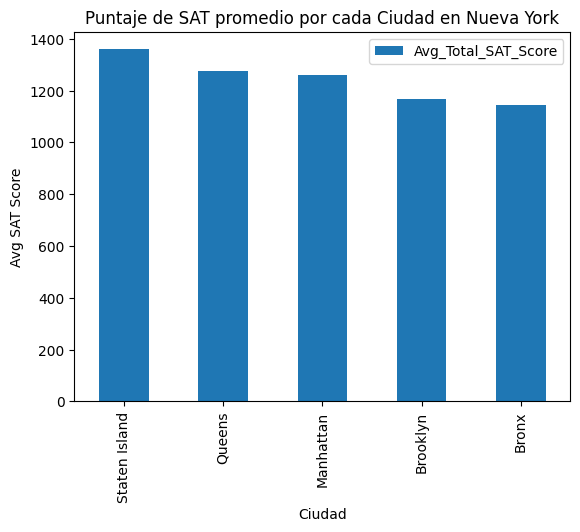

In [40]:
#Se eligen los elementos a graficar
dfAvgScoresBorough.createOrReplaceTempView("dfAvgScoresBorough_sql")
scBr_parametro = spark03.sql("""SELECT * FROM  dfAvgScoresBorough_sql""")

#Se genera la grafica de barras correspondiente
scBr_parametro = scBr_parametro.toPandas()
gra1 = scBr_parametro = scBr_parametro.plot(x="borough_name", y="Avg_Total_SAT_Score", kind = "bar")

gra1.set_xlabel('Ciudad')
gra1.set_ylabel('Avg SAT Score')
gra1.set_title('Puntaje de SAT promedio por cada Ciudad en Nueva York')

### Análisis
El gráfico muestra el puntaje promedio total del SAT por distrito en Nueva York. Staten Island tiene el puntaje promedio más alto, seguido de Queens y Manhattan, que comparten puntajes promedio similares por escuela. Se observa una ligera, pero notable disminución en los puntajes en Brooklyn y el Bronx. Ambas ciudades comparten puntajes similares y, en comparación con las otras tres, han disminuido alrededor de 100 puntos.

Text(0.5, 1.0, 'La Cantidad de Arrestos por Ciudad en NY')

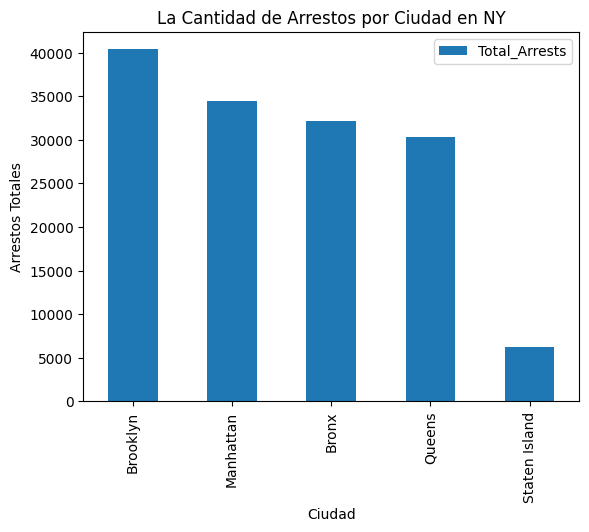

In [41]:
#Se eligen los elementos a graficar
dfArrestsBorough.createOrReplaceTempView("dfArrestsBorough_sql")
dfArrestsBorough_parametro = spark03.sql("""SELECT * FROM  dfArrestsBorough_sql""")

#Se genera la grafica de barras correspondiente
dfArrestsBorough_parametro = dfArrestsBorough_parametro.toPandas()
gra2 = dfArrestsBorough_parametro = dfArrestsBorough_parametro.plot(x="BORU_NAME", y="Total_Arrests", kind = "bar")

gra2.set_xlabel('Ciudad')
gra2.set_ylabel('Arrestos Totales')
gra2.set_title('La Cantidad de Arrestos por Ciudad en NY')

### Análisis
El gráfico muestra la cantidad de arrestos por ciudad. Brooklyn tiene la mayor cantidad de arrestos en comparación con las otras ciudades. Hay una disminución significativa en los arrestos de Brooklyn a Manhattan, con una disminución de alrededor de 5000 arrestos. De Manhattan a Bronx y Queens, la disminución no es tan significativa y tiende a disminuir en alrededor de 2000 arrestos. De Queens a Staten Island, la disminución es asombrosa. La mayor disminución en arrestos en comparación con las otras ciudades siendo de alrededor de 24000 arrestos. Esto demuestra que Staten Island se encuentra en mejores condiciones que las demás ciudades, por lo menos a nivel de arrestos.

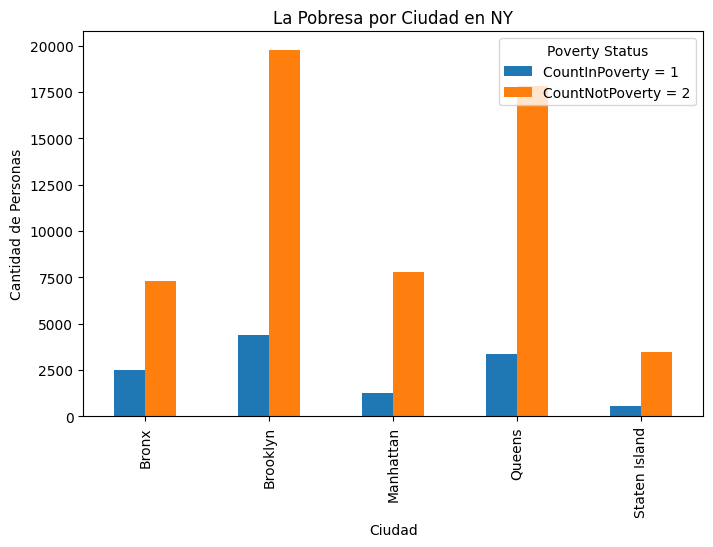

In [42]:
#Se eligen los elementos a graficar
dfPovBorough.createOrReplaceTempView("dfPovBorough_sql")
dfPovBorough_parametro = spark03.sql("""SELECT * FROM  dfPovBorough_sql""")

#Se genera la grafica de barras correspondiente
dfPovBorough_parametro = dfPovBorough_parametro.toPandas()
dfPovBorough_parametro.set_index("Borou_name", inplace=True)
gra3 =dfPovBorough_parametro =  dfPovBorough_parametro.plot(kind = "bar", figsize=(8,5))


gra3.set_xlabel('Ciudad')
gra3.set_ylabel('Cantidad de Personas')
gra3.set_title('La Pobresa por Ciudad en NY')
gra3.legend(["CountInPoverty = 1", "CountNotPoverty = 2"], title="Poverty Status")

### Análisis
El gráfico muestra la proporción de personas en situación de pobreza y personas en situación normal por ciudad. Las ciudades con mayor número de personas en situación de pobreza son Brooklyn, Queens y el Bronx respectivamente. Manhattan y Staten Island tienen un menor número de personas en situación de pobreza, sin embargo este gráfico no debe interpretarse por sus cifras, sino que debe analizarse comparando el tamaño de las barras de personas en situación de pobreza y personas sin pobreza. Esto se debe a que cada ciudad tiene una población diferente.

Visto de esta manera, el Bronx tiene la mayor proporción de personas en situación de pobreza, seguido de Brooklyn, Queens y Manhattan. Staten Island sigue siendo la ciudad con la menor proporción de personas en situación de pobreza.

Text(0.5, 1.0, 'La Cantidad de Collisiones por Ciudad en NY')

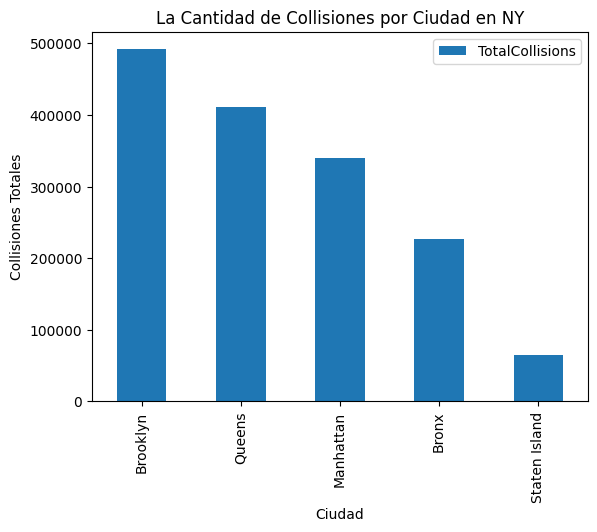

In [43]:
#Se eligen los elementos a graficar
dfAccidentsBorough.createOrReplaceTempView("dfAccidentsBorough_sql")
dfAccidentsBorough_parametro = spark03.sql("""SELECT * FROM  dfAccidentsBorough_sql""")

#Se genera la grafica de barras correspondiente
dfAccidentsBorough_parametro = dfAccidentsBorough_parametro.toPandas()
gra2 = dfAccidentsBorough_parametro = dfAccidentsBorough_parametro.plot(x="BORU_GH", y="TotalCollisions", kind = "bar")

gra2.set_xlabel('Ciudad')
gra2.set_ylabel('Collisiones Totales')
gra2.set_title('La Cantidad de Collisiones por Ciudad en NY')

### Análisis
El gráfico muestra la cantidad de colisiones por ciudad. Brooklyn tiene la mayor cantidad de colisiones entre las ciudades de Nueva York. La disminución de las colisiones parece seguir un patrón lineal, con una disminución de entre 80.000 y 100.000 personas entre ciudades. Después de Brooklyn, se encuentran Queens, Manhattan y el Bronx. En comparación con las disminuciones entre las últimas cuatro ciudades, la diferencia entre el Bronx y Staten Island ronda los 100.000-150.000, mucho mayor que las demás. Staten Island tiene la menor cantidad de colisiones en comparación con el resto.

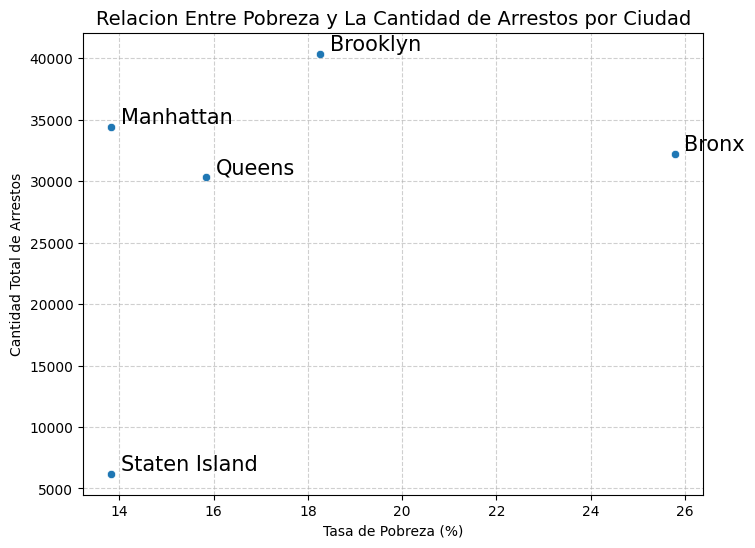

In [45]:
#Se eligen elementos a graficar
dfPovRa.createOrReplaceTempView("dfPovRa_sql")
dfPovRa_parametro=spark03.sql("""SELECT * FROM  dfPovRa_sql""")
dfPovRa_parametro=dfPovRa_parametro.toPandas()
plt.figure(figsize=(8,6))

#Se produce la grafica correspondiente
sns.scatterplot(
    data=dfPovRa_parametro,
    x='povRate',
    y='Total_Arrests'
)
for i, row in dfPovRa_parametro.iterrows():
    plt.text(row['povRate'] + 0.2, row['Total_Arrests'] + 300, row['Borou_name'], fontsize=15)

plt.title('Relacion Entre Pobreza y La Cantidad de Arrestos por Ciudad', fontsize=14)
plt.xlabel('Tasa de Pobreza (%)')
plt.ylabel('Cantidad Total de Arrestos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis
El gráfico muestra cómo el porcentaje de pobreza en la ciudad afecta la cantidad de arrestos. Staten Island, con el menor porcentaje de personas en situación de pobreza, registra la menor cantidad de arrestos. Además, se observa un gran aumento en el número de arrestos al compararse con las otras ciudades. Manhattan tiene un porcentaje bastante bajo de personas en situación de pobreza, pero también una cantidad mucho mayor de arrestos, siendo la segunda ciudad con mayor número de arrestos. La ciudad con mayor cantidad de arrestos y pobreza es el Bronx, seguida de Brooklyn, Manhattan y Queens. Manhattan, Queens, Brooklyn y el Bronx tienden a oscilar entre 40.000 y 30.000 arrestos, mientras que Staten Island tiene muchos menos arrestos que las demás ciudades.

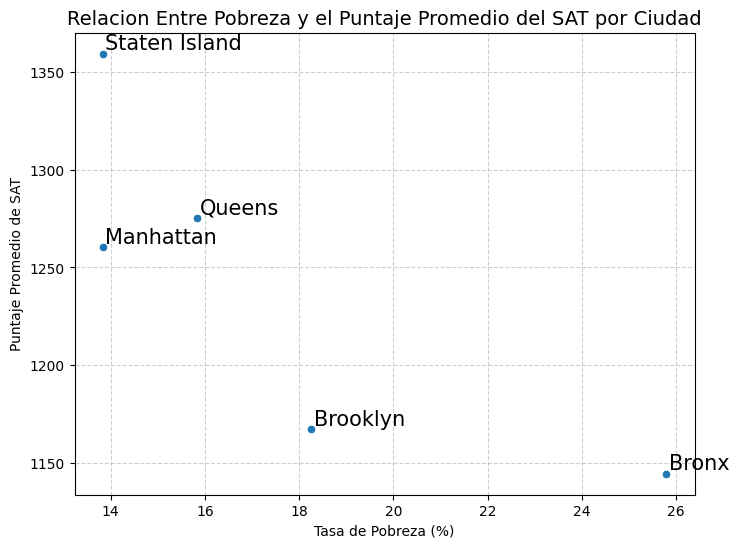

In [46]:
# Se eligen elementos a graficar
dfSATRa.createOrReplaceTempView("dfSATRa_sql")
dfSATRa_parametro=spark03.sql("""SELECT * FROM  dfSATRa_sql""")
dfSATRa_parametro=dfSATRa_parametro.toPandas()
plt.figure(figsize=(8,6))

#Se produce la grafica correspondiente
sns.scatterplot(
    data=dfSATRa_parametro,
    x='povRate',
    y='Avg_Total_SAT_Score'
)
for i, row in dfSATRa_parametro.iterrows():
    plt.text(row['povRate'] + 0.05, row['Avg_Total_SAT_Score'] + 2, row['Borou_name'], fontsize=15)

plt.title('Relacion Entre Pobreza y el Puntaje Promedio del SAT por Ciudad', fontsize=14)
plt.xlabel('Tasa de Pobreza (%)')
plt.ylabel('Puntaje Promedio de SAT')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis
El gráfico muestra la relación entre la pobreza por ciudad, y cómo esta afecta las puntuaciones del SAT por ciudad en Nueva York. Los datos parecen seguir una tendencia a medida que aumenta el porcentaje de pobreza. Staten Island se mantiene a la cabeza con el puntaje promedio más alto del SAT entre las demás ciudades. Los datos siguen una tendencia inversamente proporcional: a medida que aumenta el porcentaje de pobreza en la ciudad, el puntaje promedio del SAT por ciudad disminuye. Después de Staten Island, Queens ocupa el segundo lugar en puntaje de SAT, seguida de Manhattan, Brooklyn y el Bronx.

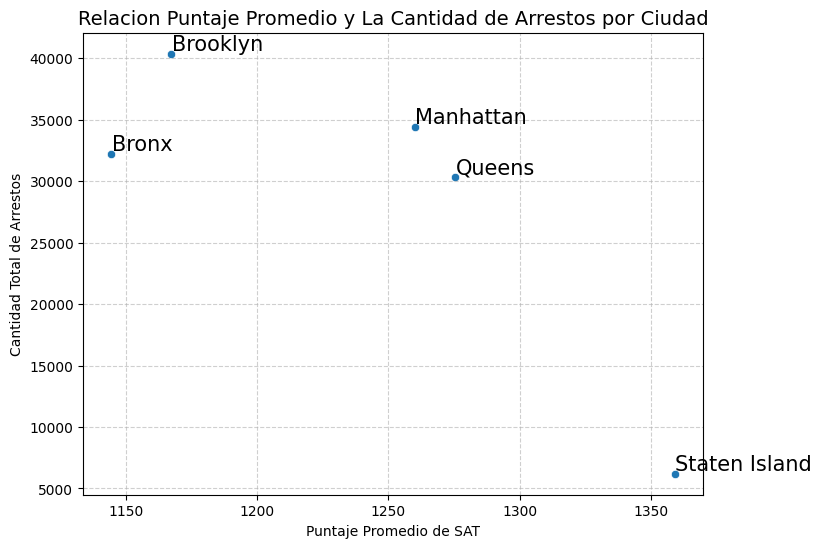

In [47]:
# Se eligen elementos a graficar
dfSATAr.createOrReplaceTempView("dfSATAr_sql")
dfSATAr_parametro=spark03.sql("""SELECT * FROM  dfSATAr_sql""")
dfSATAr_parametro=dfSATAr_parametro.toPandas()
plt.figure(figsize=(8,6))

#Se produce la grafica correspondiente
sns.scatterplot(
    data=dfSATAr_parametro,
    x='Avg_Total_SAT_Score',
    y='Total_Arrests'
)
for i, row in dfSATAr_parametro.iterrows():
    plt.text(row['Avg_Total_SAT_Score'] + 0.2, row['Total_Arrests'] + 300, row['borough_name'], fontsize=15)

plt.title('Relacion Puntaje Promedio y La Cantidad de Arrestos por Ciudad', fontsize=14)
plt.xlabel('Puntaje Promedio de SAT')
plt.ylabel('Cantidad Total de Arrestos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis
El gráfico muestra la relación entre el SAT promedio y cómo afecta este a la cantidad de arrestos por ciudad. El gráfico muestra una tendencia nuevamente inversamente proporcional: a medida que aumenta el puntaje promedio del SAT, disminuye la cantidad total de arrestos en esa ciudad. Brooklyn registra la mayor cantidad de arrestos y el segundo puntaje promedio más bajo en el SAT de la ciudad. El Bronx, Manhattan y Queens se encuentran entre los 30000 y los 35000 arrestos, pero el Bronx tiene un puntaje promedio mucho menor. Manhattan y Queens ocupan el tercer y segundo lugar, respectivamente, en cuanto a puntajes promedio más altos en el SAT.

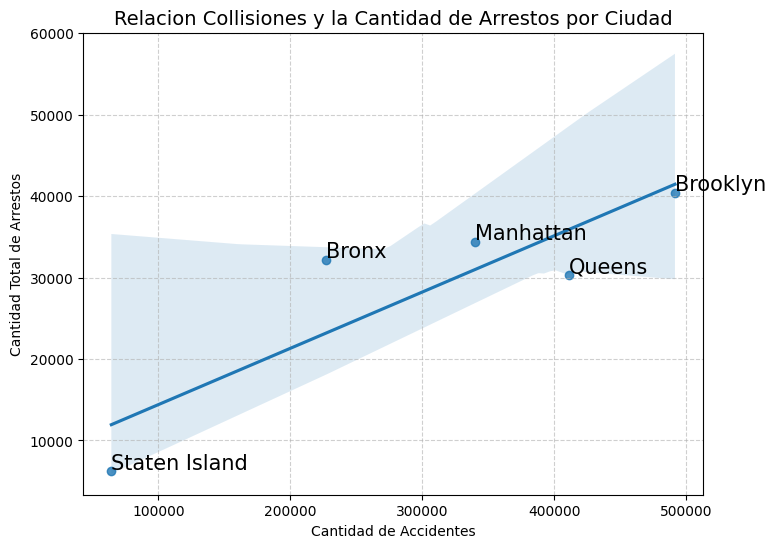

In [50]:
# Se eligen elementos a graficar
dfAcCol.createOrReplaceTempView("dfAcCol_sql")
dfAcCol_parametro=spark03.sql("""SELECT * FROM  dfAcCol_sql""")
dfAcCol_parametro=dfAcCol_parametro.toPandas()
plt.figure(figsize=(8,6))

#Se produce la grafica correspondiente
sns.regplot(
    data=dfAcCol_parametro,
    x='TotalCollisions',
    y='Total_Arrests'
)
for i, row in dfAcCol_parametro.iterrows():
    plt.text(row['TotalCollisions'] + 0.2, row['Total_Arrests'] + 300, row['BORU_GH'], fontsize=15)

plt.title('Relacion Collisiones y la Cantidad de Arrestos por Ciudad', fontsize=14)
plt.xlabel('Cantidad de Accidentes')
plt.ylabel('Cantidad Total de Arrestos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis
El gráfico muestra la relación entre colisiones y arrestos por ciudad. Existe una tendencia directamente proporcional y lineal entre los puntos de datos, que muestra que a medida que aumenta la cantidad de arrestos en accidentes de colisión, también aumenta la cantidad de arrestos. Staten Island registra la menor cantidad de arrestos y accidentes de colisión. Le siguen el Bronx, Manhattan, Queens y Brooklyn. Brooklyn registra la mayor cantidad de accidentes y, al mismo tiempo, la mayor cantidad de arrestos.